In [1]:
import pylcp
import numpy as np
from matplotlib import pyplot as plt
from scipy import constants as const

In [7]:
from scipy.optimize import curve_fit
from scipy.optimize import bisect

In [2]:
gamma = 2*np.pi*99e6 # Hz
k = 2*np.pi/229e-9 # m^-1
#t_unit = 2*np.pi/gamma
t_unit = 1e-3
m_unit = 2*np.pi/k
velocity_unit = m_unit/t_unit
accel_unit = m_unit/t_unit**2
Hz_unit = 1/t_unit
Js_unit = const.hbar # kg m^2/s
mass_unit = Js_unit*t_unit/m_unit**2
HzperT_unit = const.value("Bohr magneton")/(Js_unit)
T_unit = Hz_unit/HzperT_unit
amu_unit = mass_unit/1.66e-27
cm_unit = m_unit/1e-2
F_unit = mass_unit*m_unit/t_unit**2
I_sat = (np.pi*const.h*const.c*gamma)/(3*229e-9**3) # W/m^2

In [4]:
ksim=k*m_unit
gammasim=gamma/Hz_unit

In [5]:
Hg, Bgq = pylcp.hamiltonians.singleF(F=0, gF=0, muB=1e-4*cm_unit*HzperT_unit/Hz_unit)
He, Beq = pylcp.hamiltonians.singleF(F=1, gF=1, muB=1e-4*cm_unit*HzperT_unit/Hz_unit)
dijq = pylcp.hamiltonians.dqij_two_bare_hyperfine(0, 1)
ham = pylcp.hamiltonian(Hg, He, Bgq, Beq, dijq, mass=112/amu_unit,k=ksim, gamma=gammasim, muB=1)
mag_field = pylcp.fields.quadrupoleMagneticField(250)
mag_field2 = pylcp.fields.quadrupoleMagneticField(250/2)

In [6]:
sxy = 0.01
sz = 0.01# 0.06
#sxy=sz

def MOT_and_Slow_Beams(det_MOT, det_slower, *args):
    return pylcp.laserBeams([
        {'kvec':np.array([-1/np.sqrt(2), -1/np.sqrt(2), 0.])*ksim, 'pol':-1, 'delta':det_MOT*gammasim, 's':sxy,'wb':1/cm_unit},
        {'kvec':np.array([1/np.sqrt(2), 1/np.sqrt(2), 0.])*ksim, 'pol':-1, 'delta':det_MOT*gammasim, 's':sxy,'wb':1/cm_unit},
        {'kvec':np.array([1/np.sqrt(2), -1/np.sqrt(2), 0.])*ksim, 'pol':-1, 'delta':det_MOT*gammasim, 's':sxy,'wb':1/cm_unit},
        {'kvec':np.array([-1/np.sqrt(2), 1/np.sqrt(2), 0.])*ksim, 'pol':-1, 'delta':det_MOT*gammasim, 's':sxy,'wb':1/cm_unit},
        {'kvec':np.array([0., 0.,  1.])*ksim, 'pol':+1, 'delta':det_MOT*gammasim, 's':sz,'wb':1/cm_unit},
        {'kvec':np.array([0., 0., -1.])*ksim, 'pol':+1, 'delta':det_MOT*gammasim, 's':sz,'wb':1/cm_unit},
        {'kvec':np.array([-1, 0., 0.])*ksim, 'pol':-1, 'delta':det_slower*gammasim, 's':0,'wb':1/cm_unit}
    ], beam_type=pylcp.gaussianBeam)
    

def MOT_Beams(det_MOT, theta, *args):
    return pylcp.laserBeams([
        {'kvec':np.array([np.cos(theta), np.sin(theta), 0.])*ksim, 'pol':-1, 'delta':det_MOT*gammasim, 's':sxy,'wb':1/cm_unit},
        {'kvec':np.array([np.cos(theta), -np.sin(theta), 0.])*ksim, 'pol':-1, 'delta':det_MOT*gammasim, 's':sxy,'wb':1/cm_unit},
        {'kvec':np.array([-np.cos(theta), -np.sin(theta), 0.])*ksim, 'pol':-1, 'delta':det_MOT*gammasim, 's':sxy,'wb':1/cm_unit},
        {'kvec':np.array([-np.cos(theta), np.sin(theta), 0.])*ksim, 'pol':-1, 'delta':det_MOT*gammasim, 's':sxy,'wb':1/cm_unit},
        {'kvec':np.array([0., 0.,  1.])*ksim, 'pol':+1, 'delta':det_MOT*gammasim, 's':sz,'wb':1/cm_unit},
        {'kvec':np.array([0., 0., -1.])*ksim, 'pol':+1, 'delta':det_MOT*gammasim, 's':sz,'wb':1/cm_unit}
    ], beam_type=pylcp.gaussianBeam)
        

def MOT_Beams(det_MOT, *args):
    return pylcp.laserBeams([
        {'kvec':np.array([-1/np.sqrt(2), -1/np.sqrt(2), 0.])*ksim, 'pol':-1, 'delta':det_MOT*gammasim, 's': sxy},
        {'kvec':np.array([1/np.sqrt(2), 1/np.sqrt(2), 0.])*ksim, 'pol':-1, 'delta':det_MOT*gammasim, 's': sxy},
        {'kvec':np.array([1/np.sqrt(2), -1/np.sqrt(2), 0.])*ksim, 'pol':-1, 'delta':det_MOT*gammasim, 's': sxy},
        {'kvec':np.array([-1/np.sqrt(2), 1/np.sqrt(2), 0.])*ksim, 'pol':-1, 'delta':det_MOT*gammasim, 's': sxy},
        {'kvec':np.array([0., 0.,  1.])*ksim, 'pol':+1, 'delta':det_MOT*gammasim, 's': sz},
        {'kvec':np.array([0., 0., -1.])*ksim, 'pol':+1, 'delta':det_MOT*gammasim, 's': sz}
    ], beam_type=pylcp.infinitePlaneWaveBeam)

def MOT_Beams_xyz(det_MOT, *args):
    return pylcp.laserBeams([
        {'kvec':np.array([ 1., 0., 0.])*ksim, 'pol':-1, 'delta':det_MOT*gammasim, 's': sxy},
        {'kvec':np.array([-1., 0., 0.])*ksim, 'pol':-1, 'delta':det_MOT*gammasim, 's': sxy},
        {'kvec':np.array([ 0., 1., 0.])*ksim, 'pol':-1, 'delta':det_MOT*gammasim, 's': sxy},
        {'kvec':np.array([ 0.,-1., 0.])*ksim, 'pol':-1, 'delta':det_MOT*gammasim, 's': sxy},
        {'kvec':np.array([ 0., 0., 1.])*ksim, 'pol':+1, 'delta':det_MOT*gammasim, 's': sz},
        {'kvec':np.array([ 0., 0.,-1.])*ksim, 'pol':+1, 'delta':det_MOT*gammasim, 's': sz}
    ], beam_type=pylcp.infinitePlaneWaveBeam)

def MOT_Beams_intensity(det_MOT, sx, sy, sz, *args):
    return pylcp.laserBeams([
        {'kvec':np.array([-1/np.sqrt(2), -1/np.sqrt(2), 0.])*ksim, 'pol':-1, 'delta':det_MOT*gammasim, 's': sx},
        {'kvec':np.array([1/np.sqrt(2), 1/np.sqrt(2), 0.])*ksim, 'pol':-1, 'delta':det_MOT*gammasim, 's': sx},
        {'kvec':np.array([1/np.sqrt(2), -1/np.sqrt(2), 0.])*ksim, 'pol':-1, 'delta':det_MOT*gammasim, 's': sy},
        {'kvec':np.array([-1/np.sqrt(2), 1/np.sqrt(2), 0.])*ksim, 'pol':-1, 'delta':det_MOT*gammasim, 's': sy},
        {'kvec':np.array([0., 0.,  1.])*ksim, 'pol':+1, 'delta':det_MOT*gammasim, 's': sz},
        {'kvec':np.array([0., 0., -1.])*ksim, 'pol':+1, 'delta':det_MOT*gammasim, 's': sz}
    ], beam_type=pylcp.infinitePlaneWaveBeam)
    
def MOT_Beams2(det_MOT, *args):
    return pylcp.laserBeams([
        {'kvec':np.array([-1/np.sqrt(2), -1/np.sqrt(2), 0.])*ksim, 'pol':-1, 'delta':det_MOT*gammasim, 's': sxy,'wb':1/cm_unit},
        {'kvec':np.array([1/np.sqrt(2), 1/np.sqrt(2), 0.])*ksim, 'pol':-1, 'delta':det_MOT*gammasim, 's': sxy,'wb':1/cm_unit},
        {'kvec':np.array([1/np.sqrt(2), -1/np.sqrt(2), 0.])*ksim, 'pol':-1, 'delta':det_MOT*gammasim, 's': sxy,'wb':1/cm_unit},
        {'kvec':np.array([-1/np.sqrt(2), 1/np.sqrt(2), 0.])*ksim, 'pol':-1, 'delta':det_MOT*gammasim, 's': sxy,'wb':1/cm_unit},
        {'kvec':np.array([0., 0.,  1.])*ksim, 'pol':+1, 'delta':det_MOT*gammasim, 's': sz,'wb':1/cm_unit},
        {'kvec':np.array([0., 0., -1.])*ksim, 'pol':+1, 'delta':det_MOT*gammasim, 's': sz,'wb':1/cm_unit}
    ], beam_type=pylcp.gaussianBeam)
    
def MOT_Beams3(det_MOT, sxy, sz, prop, *args):
    return pylcp.laserBeams([
        {'kvec':np.array([-1/np.sqrt(2), -1/np.sqrt(2), 0.])*ksim, 'pol':-1, 'delta':det_MOT*gammasim, 's': sxy*prop},
        {'kvec':np.array([1/np.sqrt(2), 1/np.sqrt(2), 0.])*ksim, 'pol':-1, 'delta':det_MOT*gammasim, 's': sxy*prop},
        {'kvec':np.array([1/np.sqrt(2), -1/np.sqrt(2), 0.])*ksim, 'pol':-1, 'delta':det_MOT*gammasim, 's': sxy*prop},
        {'kvec':np.array([-1/np.sqrt(2), 1/np.sqrt(2), 0.])*ksim, 'pol':-1, 'delta':det_MOT*gammasim, 's': sxy*prop},
        {'kvec':np.array([0., 0.,  1.])*ksim, 'pol':+1, 'delta':det_MOT*gammasim, 's': sz*prop},
        {'kvec':np.array([0., 0., -1.])*ksim, 'pol':+1, 'delta':det_MOT*gammasim, 's': sz*prop},
        {'kvec':np.array([-1/np.sqrt(2), -1/np.sqrt(2), 0.])*ksim, 'pol':1, 'delta':det_MOT*gammasim, 's': sxy*(1-prop)},
        {'kvec':np.array([1/np.sqrt(2), 1/np.sqrt(2), 0.])*ksim, 'pol':1, 'delta':det_MOT*gammasim, 's': sxy*(1-prop)},
        {'kvec':np.array([1/np.sqrt(2), -1/np.sqrt(2), 0.])*ksim, 'pol':1, 'delta':det_MOT*gammasim, 's': sxy*(1-prop)},
        {'kvec':np.array([-1/np.sqrt(2), 1/np.sqrt(2), 0.])*ksim, 'pol':1, 'delta':det_MOT*gammasim, 's': sxy*(1-prop)},
        {'kvec':np.array([0., 0.,  1.])*ksim, 'pol':-1, 'delta':det_MOT*gammasim, 's': sz*(1-prop)},
        {'kvec':np.array([0., 0., -1.])*ksim, 'pol':-1, 'delta':det_MOT*gammasim, 's': sz*(1-prop)}
    ], beam_type=pylcp.infinitePlaneWaveBeam)
    
def MOT_Beams4(det_MOT, a, b, prop, *args):
    return pylcp.laserBeams([
        {'kvec':np.array([-1/np.sqrt(2), -1/np.sqrt(2), 0.])*ksim, 'pol':np.array([np.sqrt(prop),0,np.sqrt(1-prop)]),'pol_coord':"spherical_kvec", 'delta':det_MOT*gammasim, 's': a},
        {'kvec':np.array([1/np.sqrt(2), 1/np.sqrt(2), 0.])*ksim, 'pol':np.array([np.sqrt(prop),0,np.sqrt(1-prop)]),'pol_coord':"spherical_kvec", 'delta':det_MOT*gammasim, 's': a},
        {'kvec':np.array([1/np.sqrt(2), -1/np.sqrt(2), 0.])*ksim, 'pol':np.array([np.sqrt(prop),0,np.sqrt(1-prop)]),'pol_coord':"spherical_kvec", 'delta':det_MOT*gammasim, 's': a},
        {'kvec':np.array([-1/np.sqrt(2), 1/np.sqrt(2), 0.])*ksim, 'pol':np.array([np.sqrt(prop),0,np.sqrt(1-prop)]),'pol_coord':"spherical_kvec", 'delta':det_MOT*gammasim, 's': a},
        {'kvec':np.array([0., 0.,  1.])*ksim, 'pol':np.array([np.sqrt(1-prop),0,np.sqrt(prop)]),'pol_coord':"spherical_kvec", 'delta':det_MOT*gammasim, 's': b},
        {'kvec':np.array([0., 0., -1.])*ksim, 'pol':np.array([np.sqrt(1-prop),0,np.sqrt(prop)]),'pol_coord':"spherical_kvec", 'delta':det_MOT*gammasim, 's': b}
    ], beam_type=pylcp.infinitePlaneWaveBeam)

In [ ]:
# def captured_condition(t, y):
#     if sum(map(lambda x : (x*cm_unit)**2, y[-3:])) > 1e-4:
#         return -1
#     if sum(map(lambda x : (velocity_unit*x)**2, y[-6:-3])) > 0.1:
#         return -1
#     return 1

# def weak_cap_cond(v,p):
#     if sum(map(lambda x : (x*cm_unit)**2, p)) > 2e-4:
#         return -1
#     if sum(map(lambda x : (velocity_unit*x)**2, v)) > 0.2:
#         return -1
#     return 1

# def lost_condition(t, y):
#     return y[-3]*cm_unit - 8

# def backwards_lost(t, y):
#     if (y[-3]*cm_unit < -10 and y[-6]*velocity_unit < 0):
#         return -1
#     return 1

# captured_condition.terminal = True
# lost_condition.terminal = True
# backwards_lost.terminal = True

# def get_c_vel(theta):
#     rateeq = pylcp.rateeq(MOT_Beams(-1,-5), mag_field, ham,include_mag_forces=False)
#     def run_sim(vel):
#         rateeq.set_initial_position_and_velocity(np.array([-8/cm_unit, 0., 0.]),np.array([vel/velocity_unit, 0., 0.]))
#         rateeq.set_initial_pop(np.array([1., 0., 0., 0.]))
#         rateeq.evolve_motion([0., 5e-2/t_unit], progress_bar=True, max_step = 10e-5/t_unit, rtol=1e-3, atol=[1,1,1,1,1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-3/cm_unit,1e-3/cm_unit,1e-3/cm_unit],method="LSODA", events=[])
#         return is_cap

Completed in 6.16 s.                                               
Completed in 0.55 s.                                               


(-300.0, 300.0)

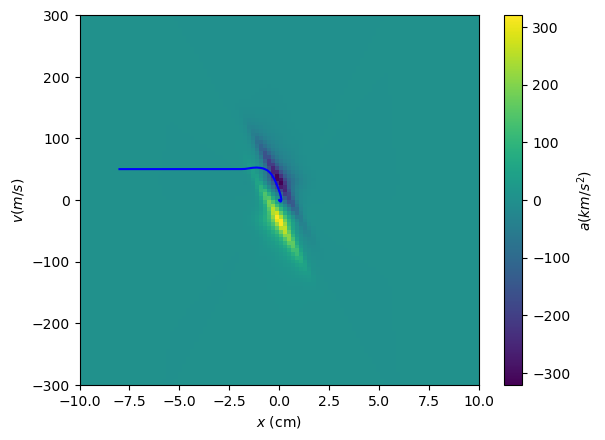

In [306]:
rateeq = pylcp.rateeq(MOT_and_Slow_Beams(-1,-5), mag_field, ham,include_mag_forces=False)

r = np.linspace(-10/cm_unit, 10./cm_unit, 100)
v = np.linspace(-300/velocity_unit, 300./velocity_unit, 100)

R, V = np.meshgrid(r, v)
rateeq.generate_force_profile([R, np.zeros(R.shape), np.zeros(R.shape)],
                           [V, np.zeros(V.shape), np.zeros(V.shape)],
                           name='Frad', progress_bar=True)

angle = float(0)
vel = float(50)

rateeq.set_initial_position_and_velocity(np.array([-8/cm_unit, 0., 0.]),np.array([vel*np.cos(np.radians(angle))/velocity_unit, vel*np.sin(np.radians(angle))/velocity_unit, 0.]))
rateeq.set_initial_pop(np.array([1., 0., 0., 0.]))
rateeq.evolve_motion([0., 5e-2/t_unit], progress_bar=True, max_step = 10e-5/t_unit, rtol=1e-3, atol=[1,1,1,1,1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-3/cm_unit,1e-3/cm_unit,1e-3/cm_unit],method="LSODA")
sol = rateeq.sol

fig, ax = plt.subplots(1, 1)
ax.plot(sol.r[0]*cm_unit,sol.v[0]*velocity_unit,'b-')
colormesh = ax.pcolormesh(R*cm_unit, V*velocity_unit, rateeq.profile['Frad'].F[0]*F_unit*1e-3/(112*1.66e-27), cmap = 'viridis')
cb1 = plt.colorbar(colormesh)
cb1.set_label('$a (km/s^2)$')
ax.set_xlabel('$x$ (cm)')
ax.set_ylabel('$v(m/s)$')
fig.subplots_adjust(left=0.12,right=0.9)
ax.set_xlim([-10,10])
ax.set_ylim([-300,300])

Completed in 5.47 s.                                               
Completed in 39:36.                                                 


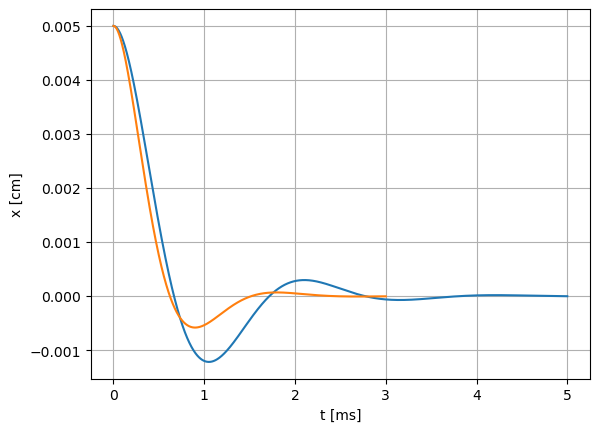

In [34]:
rateeq = pylcp.rateeq(MOT_Beams3(-1,0.02,0.02, 0.75), mag_field, ham,include_mag_forces=True)
# rateeq = pylcp.obe(MOT_Beams(-1), mag_field, ham,include_mag_forces=False)

rateeq.set_initial_position_and_velocity(np.array([0.005/cm_unit, 0., 0.]),np.array([0/velocity_unit, 0., 0.]))
rateeq.set_initial_pop(np.array([1., 0., 0., 0.]))
# rateeq.set_initial_rho_from_rateeq()
rateeq.evolve_motion([0., 5e-3/t_unit], progress_bar=True, max_step = 1e-6/t_unit, rtol=1e-3, atol=[1e-3,1e-3,1e-3,1e-3,1e-3/velocity_unit,1e-3/velocity_unit,1e-3/velocity_unit,1e-3/cm_unit,1e-3/cm_unit,1e-3/cm_unit],method="LSODA")
# rateeq.evolve_motion([0., 1e-3/t_unit], progress_bar=True, max_step = 1e-4/t_unit, rtol=1e-4, atol=[1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-3/cm_unit,1e-3/cm_unit,1e-3/cm_unit],method="LSODA")
sol = rateeq.sol

obe = pylcp.obe(MOT_Beams3(-1,0.02,0.02,0.75), mag_field2, ham,include_mag_forces=True, transform_into_re_im=True)
prec = 1e-3
obe.set_initial_position_and_velocity(np.array([0.00/cm_unit, 0.00/cm_unit, 0.005/cm_unit]),np.array([0/velocity_unit, 0., 0.]))
# rateeq.set_initial_pop(np.array([1., 0., 0., 0.]))
obe.set_initial_rho_from_rateeq()
# rateeq.evolve_motion([0., 2e-3/t_unit], progress_bar=True, max_step = 1e-5/t_unit, rtol=1e-3, atol=[1,1,1,1,1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-3/cm_unit,1e-3/cm_unit,1e-3/cm_unit],method="LSODA")
obe.evolve_motion([0., 3e-3/t_unit], progress_bar=True, max_step = 1e-5/t_unit, rtol=1e-3, atol=[prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-3/cm_unit,1e-3/cm_unit,1e-3/cm_unit],method="LSODA",random_recoil=False,freeze_axis=[True,True,False])

sol2 = obe.sol

fig, ax = plt.subplots(1, 1)
ax.plot(sol.t*t_unit*1000,sol.r[0]*cm_unit)
ax.plot(sol2.t*t_unit*1000,sol2.r[2]*cm_unit)
ax.set_xlabel('t [ms]')
ax.set_ylabel('x [cm]')
fig.subplots_adjust(left=0.12,right=0.9)
ax.grid(True)

Completed in 4.71 s.                                               
Completed in 4.73 s.                                               


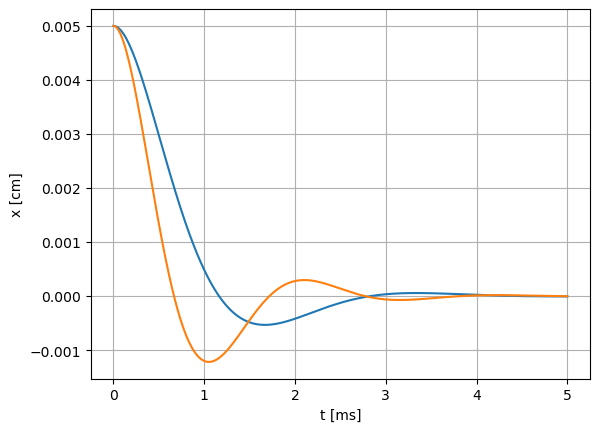

In [10]:
rateeq = pylcp.rateeq(MOT_Beams4(-1,0.02,0.02,0.75), mag_field2, ham,include_mag_forces=True)
# rateeq = pylcp.obe(MOT_Beams(-1), mag_field, ham,include_mag_forces=False)

rateeq.set_initial_position_and_velocity(np.array([0.00/cm_unit, 0., 0.005/cm_unit]),np.array([0/velocity_unit, 0., 0.]))
rateeq.set_initial_pop(np.array([1., 0., 0., 0.]))
# rateeq.set_initial_rho_from_rateeq()
rateeq.evolve_motion([0., 5e-3/t_unit], progress_bar=True, max_step = 1e-6/t_unit, rtol=1e-3, atol=[1e-3,1e-3,1e-3,1e-3,1e-3/velocity_unit,1e-3/velocity_unit,1e-3/velocity_unit,1e-3/cm_unit,1e-3/cm_unit,1e-3/cm_unit],method="LSODA")
# rateeq.evolve_motion([0., 1e-3/t_unit], progress_bar=True, max_step = 1e-4/t_unit, rtol=1e-4, atol=[1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-3/cm_unit,1e-3/cm_unit,1e-3/cm_unit],method="LSODA")
sol = rateeq.sol

rateeq = pylcp.rateeq(MOT_Beams4(-1,0.02,0.02,1), mag_field2, ham,include_mag_forces=True)
# rateeq = pylcp.obe(MOT_Beams(-1), mag_field, ham,include_mag_forces=False)

rateeq.set_initial_position_and_velocity(np.array([0.00/cm_unit, 0., 0.005/cm_unit]),np.array([0/velocity_unit, 0., 0.]))
rateeq.set_initial_pop(np.array([1., 0., 0., 0.]))
# rateeq.set_initial_rho_from_rateeq()
rateeq.evolve_motion([0., 5e-3/t_unit], progress_bar=True, max_step = 1e-6/t_unit, rtol=1e-3, atol=[1e-3,1e-3,1e-3,1e-3,1e-3/velocity_unit,1e-3/velocity_unit,1e-3/velocity_unit,1e-3/cm_unit,1e-3/cm_unit,1e-3/cm_unit],method="LSODA")
# rateeq.evolve_motion([0., 1e-3/t_unit], progress_bar=True, max_step = 1e-4/t_unit, rtol=1e-4, atol=[1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-3/cm_unit,1e-3/cm_unit,1e-3/cm_unit],method="LSODA")
sol2 = rateeq.sol

fig, ax = plt.subplots(1, 1)
ax.plot(sol.t*t_unit*1000,sol.r[2]*cm_unit)
ax.plot(sol.t*t_unit*1000,sol2.r[2]*cm_unit)
ax.set_xlabel('t [ms]')
ax.set_ylabel('x [cm]')
fig.subplots_adjust(left=0.12,right=0.9)
ax.grid(True)

Completed in 4.84 s.                                               
Completed in 29:22.                                                 


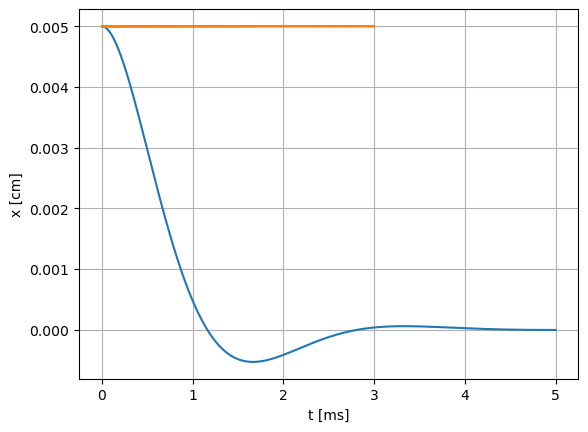

In [13]:
rateeq = pylcp.rateeq(MOT_Beams4(-1,0.02,0.02,0.75), mag_field, ham,include_mag_forces=True)
# rateeq = pylcp.obe(MOT_Beams(-1), mag_field, ham,include_mag_forces=False)

rateeq.set_initial_position_and_velocity(np.array([0.005/cm_unit, 0., 0.]),np.array([0/velocity_unit, 0., 0.]))
rateeq.set_initial_pop(np.array([1., 0., 0., 0.]))
# rateeq.set_initial_rho_from_rateeq()
rateeq.evolve_motion([0., 5e-3/t_unit], progress_bar=True, max_step = 1e-6/t_unit, rtol=1e-3, atol=[1e-3,1e-3,1e-3,1e-3,1e-3/velocity_unit,1e-3/velocity_unit,1e-3/velocity_unit,1e-3/cm_unit,1e-3/cm_unit,1e-3/cm_unit],method="LSODA")
# rateeq.evolve_motion([0., 1e-3/t_unit], progress_bar=True, max_step = 1e-4/t_unit, rtol=1e-4, atol=[1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-3/cm_unit,1e-3/cm_unit,1e-3/cm_unit],method="LSODA")
sol = rateeq.sol

obe = pylcp.obe(MOT_Beams4(-1,0.02,0.02,0.75), mag_field2, ham,include_mag_forces=True, transform_into_re_im=True)
prec = 1e-3
obe.set_initial_position_and_velocity(np.array([0.00/cm_unit, 0.00/cm_unit, 0.005/cm_unit]),np.array([0/velocity_unit, 0., 0.]))
# rateeq.set_initial_pop(np.array([1., 0., 0., 0.]))
obe.set_initial_rho_from_rateeq()
# rateeq.evolve_motion([0., 2e-3/t_unit], progress_bar=True, max_step = 1e-5/t_unit, rtol=1e-3, atol=[1,1,1,1,1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-3/cm_unit,1e-3/cm_unit,1e-3/cm_unit],method="LSODA")
obe.evolve_motion([0., 3e-3/t_unit], progress_bar=True, max_step = 1e-5/t_unit, rtol=1e-3, atol=[prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-3/cm_unit,1e-3/cm_unit,1e-3/cm_unit],method="LSODA",random_recoil=False,freeze_axis=[True,True,False])

sol2 = obe.sol

fig, ax = plt.subplots(1, 1)
ax.plot(sol.t*t_unit*1000,sol.r[0]*cm_unit)
ax.plot(sol2.t*t_unit*1000,sol2.r[2]*cm_unit)
ax.set_xlabel('t [ms]')
ax.set_ylabel('x [cm]')
fig.subplots_adjust(left=0.12,right=0.9)
ax.grid(True)

Completed in 5.65 s.                                               
Completed in 39:59.                                                 


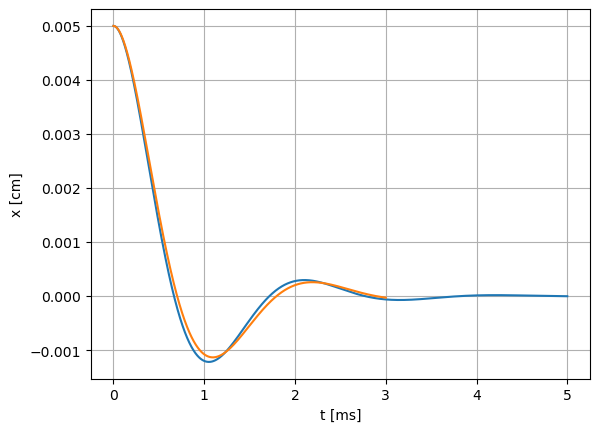

In [32]:
rateeq = pylcp.rateeq(MOT_Beams3(-1,0.02,0.02,1), mag_field, ham,include_mag_forces=True)
# rateeq = pylcp.obe(MOT_Beams(-1), mag_field, ham,include_mag_forces=False)

rateeq.set_initial_position_and_velocity(np.array([0.005/cm_unit, 0., 0.]),np.array([0/velocity_unit, 0., 0.]))
rateeq.set_initial_pop(np.array([1., 0., 0., 0.]))
# rateeq.set_initial_rho_from_rateeq()
rateeq.evolve_motion([0., 5e-3/t_unit], progress_bar=True, max_step = 1e-6/t_unit, rtol=1e-3, atol=[1e-3,1e-3,1e-3,1e-3,1e-3/velocity_unit,1e-3/velocity_unit,1e-3/velocity_unit,1e-3/cm_unit,1e-3/cm_unit,1e-3/cm_unit],method="LSODA")
# rateeq.evolve_motion([0., 1e-3/t_unit], progress_bar=True, max_step = 1e-4/t_unit, rtol=1e-4, atol=[1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-3/cm_unit,1e-3/cm_unit,1e-3/cm_unit],method="LSODA")
sol = rateeq.sol

obe = pylcp.obe(MOT_Beams3(-1,0.02,0.02,1), mag_field2, ham,include_mag_forces=True, transform_into_re_im=True)
prec = 1e-3
obe.set_initial_position_and_velocity(np.array([0.00/cm_unit, 0.00/cm_unit, 0.005/cm_unit]),np.array([0/velocity_unit, 0., 0.]))
# rateeq.set_initial_pop(np.array([1., 0., 0., 0.]))
obe.set_initial_rho_from_rateeq()
# rateeq.evolve_motion([0., 2e-3/t_unit], progress_bar=True, max_step = 1e-5/t_unit, rtol=1e-3, atol=[1,1,1,1,1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-3/cm_unit,1e-3/cm_unit,1e-3/cm_unit],method="LSODA")
obe.evolve_motion([0., 3e-3/t_unit], progress_bar=True, max_step = 1e-5/t_unit, rtol=1e-3, atol=[prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-3/cm_unit,1e-3/cm_unit,1e-3/cm_unit],method="LSODA",random_recoil=False,freeze_axis=[True,True,False])

sol2 = obe.sol

fig, ax = plt.subplots(1, 1)
ax.plot(sol.t*t_unit*1000,sol.r[0]*cm_unit)
ax.plot(sol2.t*t_unit*1000,sol2.r[2]*cm_unit)
ax.set_xlabel('t [ms]')
ax.set_ylabel('x [cm]')
fig.subplots_adjust(left=0.12,right=0.9)
ax.grid(True)

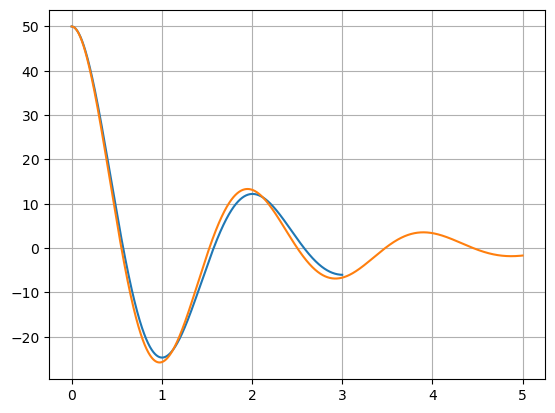

In [370]:
plt.plot(*(lambda x : [x.t*t_unit*1000,x.r[2]*cm_unit*1e4])(freqs[0][2]))
plt.plot(*(lambda x : [x.t*t_unit*1000,x.r[0]*cm_unit*1e4])(rateeq.sol))
plt.grid()

Completed in 0.15 s.                                              


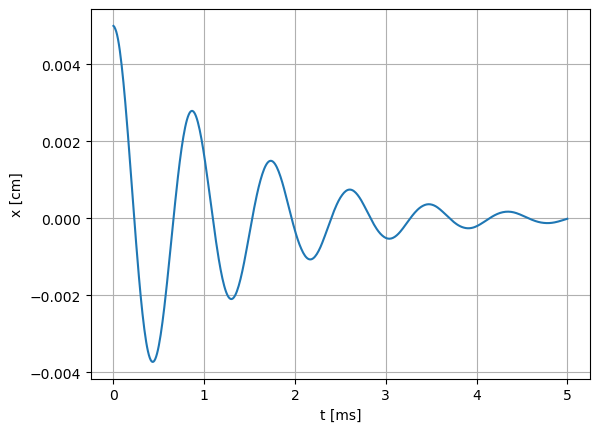

In [371]:
rateeq = pylcp.heuristiceq(MOT_Beams(-1), mag_field, mass=112/amu_unit,gamma=gammasim,k=ksim)
# rateeq = pylcp.obe(MOT_Beams(-1), mag_field, ham,include_mag_forces=False)

rateeq.set_initial_position_and_velocity(np.array([0.005/cm_unit, 0., 0.]),np.array([0/velocity_unit, 0., 0.]))
# rateeq.set_initial_rho_from_rateeq()
rateeq.evolve_motion([0., 5e-3/t_unit], progress_bar=True, max_step = 1e-5/t_unit, rtol=1e-3, atol=[1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-3/cm_unit,1e-3/cm_unit,1e-3/cm_unit],method="LSODA")
# rateeq.evolve_motion([0., 1e-3/t_unit], progress_bar=True, max_step = 1e-4/t_unit, rtol=1e-4, atol=[1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-3/cm_unit,1e-3/cm_unit,1e-3/cm_unit],method="LSODA")
sol = rateeq.sol

fig, ax = plt.subplots(1, 1)
ax.plot(sol.t*t_unit*1000,sol.r[0]*cm_unit)
ax.set_xlabel('t [ms]')
ax.set_ylabel('x [cm]')
fig.subplots_adjust(left=0.12,right=0.9)
ax.grid(True)

In [323]:
# rateeq = pylcp.rateeq(MOT_Beams(-1), mag_field, ham,include_mag_forces=False)
obe = pylcp.obe(MOT_Beams(-1), mag_field, ham,include_mag_forces=True, transform_into_re_im=True)
prec = 1e-3

r =  np.linspace(-5/cm_unit, 5./cm_unit, 100)
v =  np.linspace(-300/velocity_unit, 300./velocity_unit, 100)

R, V = np.meshgrid(r, v)
obe.generate_force_profile([R, np.zeros(R.shape), np.zeros(R.shape)],
                           [V, np.zeros(V.shape), np.zeros(V.shape)],
                           name='Frad', progress_bar=True,deltat_tmax=100/gammasim, deltat_r=1e-2/cm_unit,itermax=1000,atol=[prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-3/cm_unit,1e-3/cm_unit,1e-3/cm_unit],
                           method="RK23")

fig, ax = plt.subplots(1, 1)
colormesh = ax.pcolormesh(R*cm_unit, V*velocity_unit, obe.profile['Frad'].F[0]*F_unit*1e-3/(112*1.66e-27), cmap = 'viridis')
cb1 = plt.colorbar(colormesh)
cb1.set_label('$a (km/s^2)$')
ax.set_xlabel('$x$ (cm)')
ax.set_ylabel('$v(m/s)$')
fig.subplots_adjust(left=0.12,right=0.9)
ax.set_xlim([-5,5])
ax.set_ylim([-300,300])

KeyboardInterrupt: 

(-300.0, 300.0)

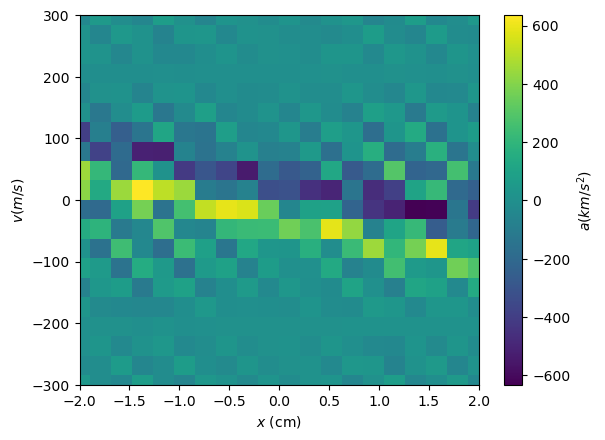

In [ ]:
fig, ax = plt.subplots(1, 1)
colormesh = ax.pcolormesh(R*cm_unit, V*velocity_unit, obe.profile['Frad'].F[0]*F_unit*1e-3/(112*1.66e-27), cmap = 'viridis')
cb1 = plt.colorbar(colormesh)
cb1.set_label('$a (km/s^2)$')
ax.set_xlabel('$x$ (cm)')
ax.set_ylabel('$v(m/s)$')
fig.subplots_adjust(left=0.12,right=0.9)
ax.set_xlim([-2,2])
ax.set_ylim([-300,300])

Completed in 1:05:41.                                                 


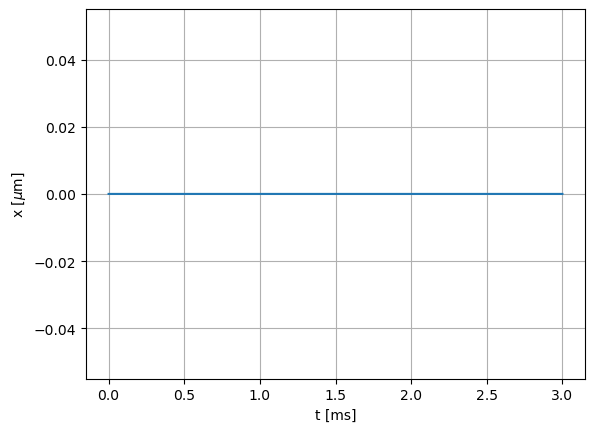

In [8]:
# rateeq = pylcp.rateeq(MOT_Beams(-1), mag_field, ham,include_mag_forces=False)
obe = pylcp.obe(MOT_Beams_intensity(-1.45,2/6,2/6,2/6), mag_field, ham,include_mag_forces=True, transform_into_re_im=True)

prec = 1e-3
obe.set_initial_position_and_velocity(np.array([0.00/cm_unit, 0.00/cm_unit, 0.005/cm_unit]),np.array([0/velocity_unit, 0., 0.]))
# rateeq.set_initial_pop(np.array([1., 0., 0., 0.]))
obe.set_initial_rho_from_rateeq()
# rateeq.evolve_motion([0., 2e-3/t_unit], progress_bar=True, max_step = 1e-5/t_unit, rtol=1e-3, atol=[1,1,1,1,1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-3/cm_unit,1e-3/cm_unit,1e-3/cm_unit],method="LSODA")
obe.evolve_motion([0., 3e-3/t_unit], progress_bar=True, max_step = 1e-5/t_unit, rtol=1e-3, atol=[prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-3/cm_unit,1e-3/cm_unit,1e-3/cm_unit],method="LSODA",random_recoil=False,freeze_axis=[True,True,False])
sol = obe.sol

fig, ax = plt.subplots(1, 1)
ax.plot(sol.t*t_unit*1000,sol.r[0]*cm_unit*1e4)
ax.set_xlabel('t [ms]')
ax.set_ylabel('x [$\\mu$m]')
fig.subplots_adjust(left=0.12,right=0.9)
ax.grid(True)

(0.0, 3.0)

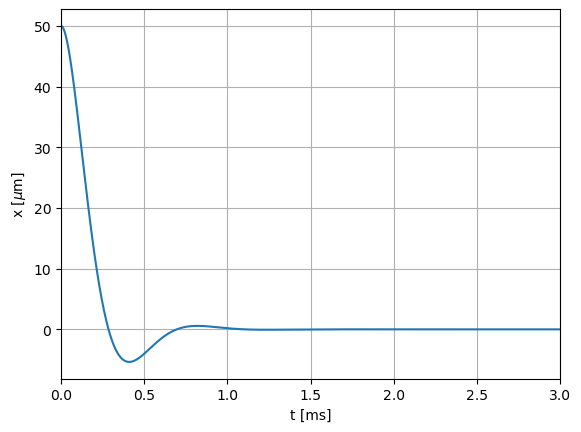

In [9]:
fig, ax = plt.subplots(1, 1)
ax.plot(sol.t*t_unit*1000,sol.r[2]*cm_unit*1e4)
ax.set_xlabel('t [ms]')
ax.set_ylabel('x [$\\mu$m]')
fig.subplots_adjust(left=0.12,right=0.9)
ax.grid(True)
ax.set_xlim(0,3)

In [351]:
def get_frequencies(s):
    # rateeq = pylcp.rateeq(MOT_Beams(-1), mag_field, ham,include_mag_forces=False)
    obe = pylcp.obe(MOT_Beams_intensity(-1,s,s,s), mag_field, ham,include_mag_forces=True, transform_into_re_im=True)

    prec = 1e-3
    obe.set_initial_position_and_velocity(np.array([0.00/cm_unit, 0.00/cm_unit, 0.005/cm_unit]),np.array([0/velocity_unit, 0., 0.]))
    # rateeq.set_initial_pop(np.array([1., 0., 0., 0.]))
    obe.set_initial_rho_from_rateeq()
    # rateeq.evolve_motion([0., 2e-3/t_unit], progress_bar=True, max_step = 1e-5/t_unit, rtol=1e-3, atol=[1,1,1,1,1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-3/cm_unit,1e-3/cm_unit,1e-3/cm_unit],method="LSODA")
    obe.evolve_motion([0., 3e-3/t_unit], progress_bar=True, max_step = 1e-5/t_unit, rtol=1e-3, atol=[prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,prec,1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-3/cm_unit,1e-3/cm_unit,1e-3/cm_unit],method="LSODA",random_recoil=False,freeze_axis=[True,True,False])
    sol = obe.sol

    fitfunc = lambda t, *args: args[0]*np.exp(-args[1]*t/2)*np.cos(np.sqrt((args[2])**2 - (args[1])**2/4)*t + args[3]) + args[4]
    fit, cov = curve_fit(fitfunc, sol.t*t_unit, sol.r[2]*cm_unit, p0=[0.05,3e3,3e3,0,0], maxfev=100000)
    print(fit[1],"+-",np.sqrt(cov[1,1]))
    print(fit[2],"+-",np.sqrt(cov[2,2]))
    print((fit[2])**2/(fit[1]))
    return fit[1], fit[2], sol

In [353]:
freqs = [get_frequencies(s) for s in [0.01,0.02,0.03,0.04,0.05,0.1,0.2]]

Completed in 33:40.                                                 
1405.5923635834445 +- 1.5109385657361815e-05
3210.6300528056377 +- 9.259897104544578e-06
7333.666291199068
Completed in 35:12.                                                 
2709.2819945706137 +- 2.562927697140476e-05
4486.017444134861 +- 1.761378796324321e-05
7427.928340206506
Completed in 35:33.                                                 
3935.8183172670783 +- 2.36776002719457e-05
5420.699452079948 +- 1.685350612567548e-05
7465.7873359823325
Completed in 35:41.                                                 
5081.12375848464 +- 2.42060098360377e-05
6176.460102846901 +- 1.747891184022389e-05
7507.917778691685
Completed in 35:18.                                                 
6145.586452126914 +- 2.5744024418794118e-05
6815.82927285141 +- 1.8460220521290284e-05
7559.169338604043
Completed in 5:08:03.                                               


C:\Users\LP618\AppData\Local\Temp\ipykernel_15192\3583591601.py:13: RuntimeWarning: invalid value encountered in sqrt
  fitfunc = lambda t, *args: args[0]*np.exp(-args[1]*t/2)*np.cos(np.sqrt((args[2])**2 - (args[1])**2/4)*t + args[3]) + args[4]


10510.770289477166 +- 3.943111906448943e-05
9021.148164166147 +- 2.426407086639075e-05
7742.640354466956
Completed in 45:54.                                                 
15774.345958527007 +- 6.433614428237635e-05
11183.393918565574 +- 3.1869433704918404e-05
7928.588599909738


In [451]:
def get_frequencies_rateeq(sxy,sz):
    print(f"{sxy},{sz}")
    rateeq = pylcp.rateeq(MOT_Beams_intensity(-1,sxy,sxy,sz), mag_field, ham,include_mag_forces=False)
    # rateeq = pylcp.obe(MOT_Beams(-1), mag_field, ham,include_mag_forces=False)

    rateeq.set_initial_position_and_velocity(np.array([0.005/cm_unit, 0., 0.]),np.array([0/velocity_unit, 0., 0.]))
    rateeq.set_initial_pop(np.array([1., 0., 0., 0.]))
    # rateeq.set_initial_rho_from_rateeq()
    rateeq.evolve_motion([0., 5e-3/t_unit], progress_bar=True, max_step = 1e-6/t_unit, rtol=1e-3, atol=[1e-3,1e-3,1e-3,1e-3,1e-3/velocity_unit,1e-3/velocity_unit,1e-3/velocity_unit,1e-3/cm_unit,1e-3/cm_unit,1e-3/cm_unit],method="LSODA")
    # rateeq.evolve_motion([0., 1e-3/t_unit], progress_bar=True, max_step = 1e-4/t_unit, rtol=1e-4, atol=[1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-3/cm_unit,1e-3/cm_unit,1e-3/cm_unit],method="LSODA")
    sol = rateeq.sol
    
    
    fitfunc = lambda t, *args: args[0]*np.exp(-args[1]*t/2)*np.cos(np.sqrt((args[2])**2 - (args[1])**2/4)*t + args[3]) + args[4]
    fit, cov = curve_fit(fitfunc, sol.t*t_unit, sol.r[0]*cm_unit, p0=[0.005,3e3,3e3,0,0], maxfev=100000)

    return fit, sol

In [464]:
s1 = np.linspace(0.01,1,100)
s2 = np.linspace(0.1,10,100)
SXY, SZ = np.meshgrid(s1,s2)

freqs = [[get_frequencies_rateeq(sxy,sz) for sxy, sz in zip(sxy1, sz1) ] for sxy1, sz1 in zip(SXY,SZ)]

0.01,0.1
Completed in 4.06 s.                                               
0.02,0.1
Completed in 3.57 s.                                               
0.03,0.1
Completed in 3.65 s.                                               
0.04,0.1
Completed in 3.45 s.                                               
0.05,0.1
Completed in 3.45 s.                                               
0.060000000000000005,0.1
Completed in 3.48 s.                                               
0.06999999999999999,0.1
Completed in 3.55 s.                                               
0.08,0.1
Completed in 3.54 s.                                               
0.09,0.1
Completed in 3.45 s.                                               
0.09999999999999999,0.1
Completed in 3.44 s.                                               
0.11,0.1
Completed in 3.44 s.                                               
0.12,0.1
Completed in 3.45 s.                                               
0.13,0.1
Completed in 3.39 s. 

C:\Users\LP618\AppData\Local\Temp\ipykernel_15192\2210154828.py:14: RuntimeWarning: invalid value encountered in sqrt
  fitfunc = lambda t, *args: args[0]*np.exp(-args[1]*t/2)*np.cos(np.sqrt((args[2])**2 - (args[1])**2/4)*t + args[3]) + args[4]


Completed in 3.37 s.                                               
0.18000000000000002,0.1
Completed in 3.39 s.                                               
0.19,0.1
Completed in 3.69 s.                                               
0.2,0.1
Completed in 3.74 s.                                               
0.21000000000000002,0.1
Completed in 3.88 s.                                               
0.22,0.1
Completed in 3.69 s.                                               
0.23,0.1
Completed in 3.57 s.                                               
0.24000000000000002,0.1
Completed in 4.01 s.                                                
0.25,0.1
Completed in 3.52 s.                                               
0.26,0.1
Completed in 3.44 s.                                               
0.27,0.1
Completed in 3.77 s.                                               
0.28,0.1
Completed in 3.61 s.                                               
0.29000000000000004,0.1
Completed in 3.3

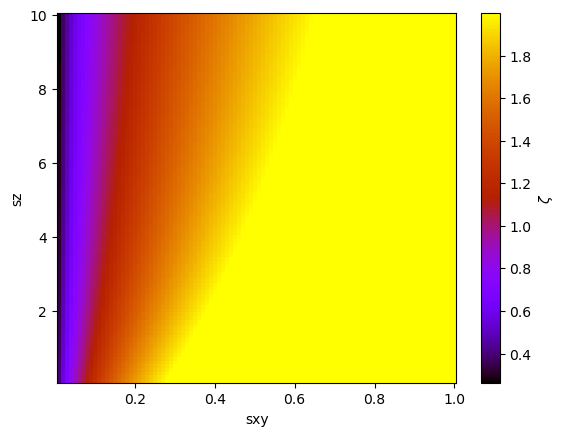

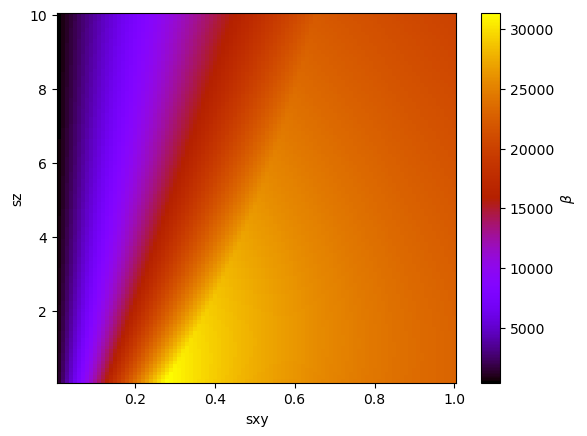

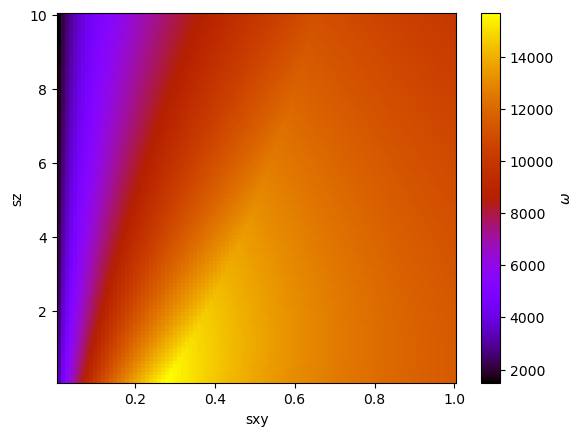

In [465]:
fig, ax = plt.subplots(1, 1)
colormesh = ax.pcolormesh(SXY, SZ, [[j[0][1]/j[0][2] for j in i] for i in freqs], cmap = 'gnuplot')
cb1 = plt.colorbar(colormesh)
cb1.set_label('$\\zeta$')
ax.set_xlabel('sxy')
ax.set_ylabel('sz')
fig.subplots_adjust(left=0.12,right=0.9)
fig, ax = plt.subplots(1, 1)
colormesh = ax.pcolormesh(SXY, SZ, [[j[0][1] for j in i] for i in freqs], cmap = 'gnuplot')
cb1 = plt.colorbar(colormesh)
cb1.set_label('$\\beta$')
ax.set_xlabel('sxy')
ax.set_ylabel('sz')
fig.subplots_adjust(left=0.12,right=0.9)
fig, ax = plt.subplots(1, 1)
colormesh = ax.pcolormesh(SXY, SZ, [[j[0][2] for j in i] for i in freqs], cmap = 'gnuplot')
cb1 = plt.colorbar(colormesh)
cb1.set_label('$\\omega$')
ax.set_xlabel('sxy')
ax.set_ylabel('sz')
fig.subplots_adjust(left=0.12,right=0.9)

In [467]:
fits=np.array([[j[0] for j in i] for i in freqs])
raw_data=np.array([[j[1]for j in i] for i in freqs])

In [470]:
np.savez("trap_freq_1gamma_250Gpercmradial.npz",SXY=SXY,SZ=SZ,fits=fits,raw_data=raw_data)

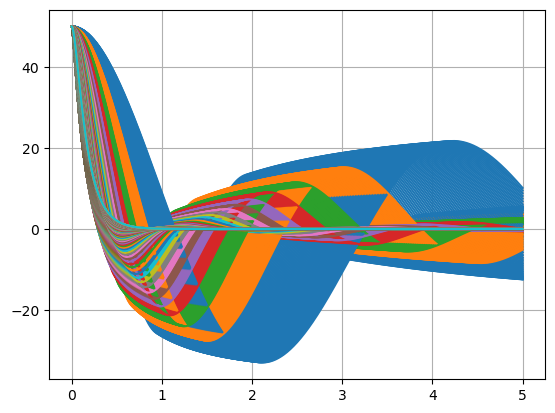

In [471]:
[[plt.plot(d[1].t*t_unit*1000,d[1].r[0]*cm_unit*1e4,label=f"{s1}|{s2}") for s2, d in zip(SXY[0],d1)] for s1,d1 in zip(SZ[:,0],freqs)]
plt.grid()
#plt.legend()

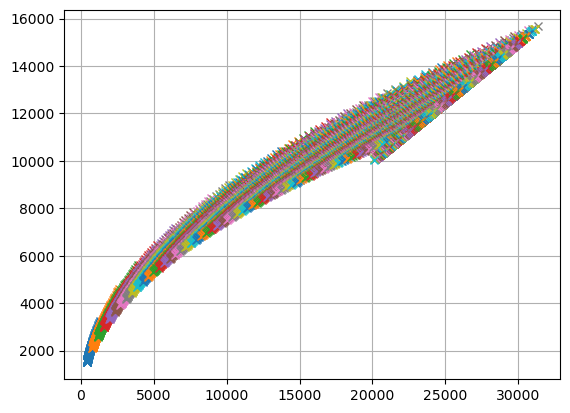

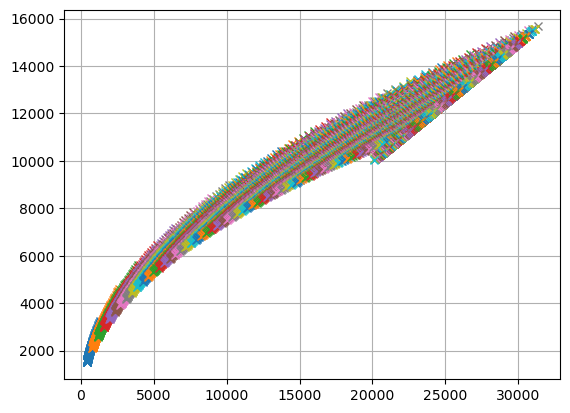

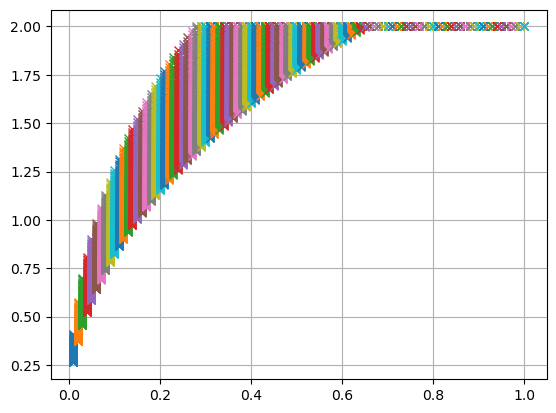

In [472]:
plt.figure()
[[plt.plot(d[0][1],d[0][2],"x",label=f"{s1}|{s2}") for s2, d in zip(SXY[0],d1)] for s1,d1 in zip(SZ[:,0],freqs)]
plt.grid()
plt.figure()
[[plt.plot(d[0][1],d[0][2],"x",label=f"{s1}|{s2}") for s2, d in zip(SXY[0],d1)] for s1,d1 in zip(SZ[:,0],freqs)]
plt.grid()
plt.figure()
[[plt.plot(s2,d[0][1]/d[0][2],"x",label=f"{s1}|{s2}") for s2, d in zip(SXY[0],d1)] for s1,d1 in zip(SZ[:,0],freqs)]
plt.grid()

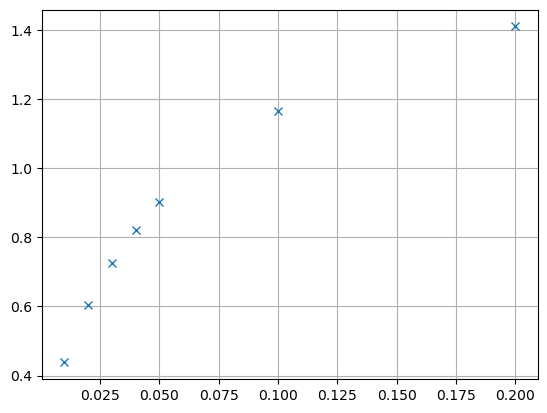

In [357]:
plt.plot([0.01,0.02,0.03,0.04,0.05,0.1,0.2], np.asarray(freqs)[:,0]/np.asarray(freqs)[:,1],'x')
plt.grid()

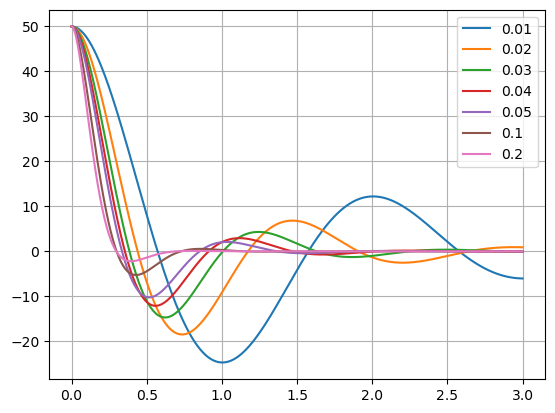

In [359]:
[plt.plot(d[2].t*t_unit*1000,d[2].r[2]*cm_unit*1e4,label=f"{s}") for s,d in zip([0.01,0.02,0.03,0.04,0.05,0.1,0.2],freqs)]
plt.grid()
plt.legend()

Completed in 28:25.                                                 


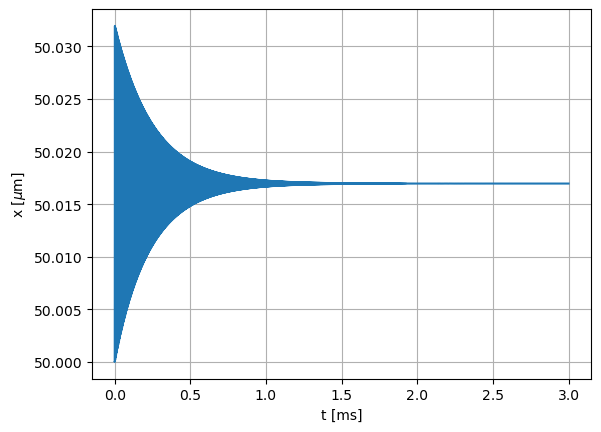

In [ ]:
# rateeq = pylcp.rateeq(MOT_Beams(-1), mag_field, ham,include_mag_forces=False)
obe2 = pylcp.obe(MOT_Beams(-1), mag_field, ham,include_mag_forces=False)

obe2.set_initial_position_and_velocity(np.array([0.005/cm_unit, 0., 0.00/cm_unit]),np.array([0/velocity_unit, 0., 0.]))
# rateeq.set_initial_pop(np.array([1., 0., 0., 0.]))
obe2.set_initial_rho_from_rateeq()
# rateeq.evolve_motion([0., 2e-3/t_unit], progress_bar=True, max_step = 1e-5/t_unit, rtol=1e-3, atol=[1,1,1,1,1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-3/cm_unit,1e-3/cm_unit,1e-3/cm_unit],method="LSODA")
obe2.evolve_motion([0., 3e-3/t_unit], progress_bar=True, max_step = 1e-5/t_unit, rtol=1e-3, atol=[1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-3/cm_unit,1e-3/cm_unit,1e-3/cm_unit],method="LSODA",random_recoil=False,freeze_axis=[False,True,True])
sol2 = obe2.sol

fig, ax = plt.subplots(1, 1)
ax.plot(sol2.t*t_unit*1000,sol2.r[0]*cm_unit*1e4)
ax.set_xlabel('t [ms]')
ax.set_ylabel('x [$\\mu$m]')
fig.subplots_adjust(left=0.12,right=0.9)
ax.grid(True)

(0.0, 3.0)

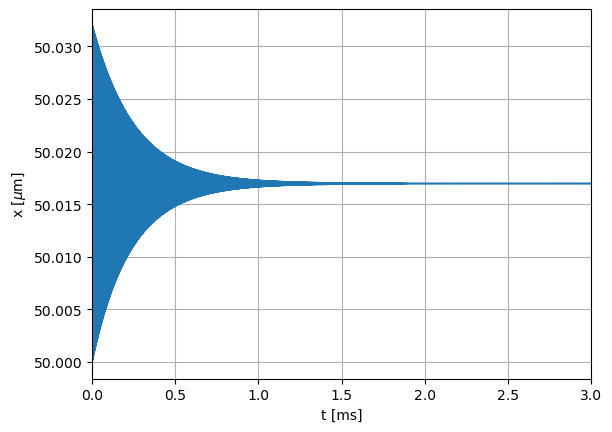

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(sol2.t*t_unit*1000,sol2.r[0]*cm_unit*1e4)
ax.set_xlabel('t [ms]')
ax.set_ylabel('x [$\\mu$m]')
fig.subplots_adjust(left=0.12,right=0.9)
ax.grid(True)
ax.set_xlim(0,3)

C:\Users\LP618\AppData\Local\Temp\ipykernel_15192\1117681335.py:1: RuntimeWarning: invalid value encountered in sqrt
  fitfunc = lambda t, *args: args[0]*np.exp(-args[1]*t/2)*np.cos(np.sqrt((args[2])**2 - (args[1])**2/4)*t + args[3]) + args[4]


204.58719168448064 +- 2.4421109947846162e-05
1269.9750091278586 +- 5.370094610270093e-06
7883.369973114741


(0.0, 3.0)

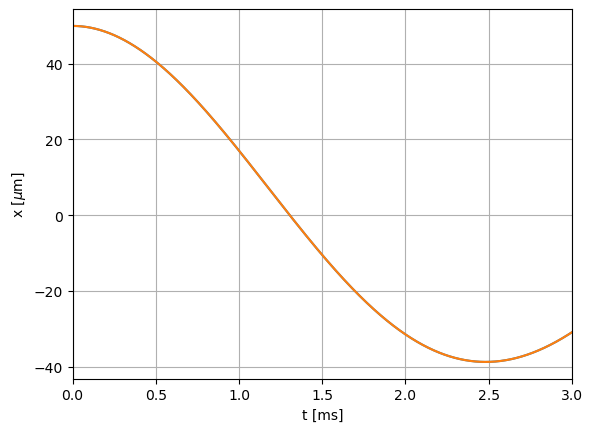

In [341]:
fitfunc = lambda t, *args: args[0]*np.exp(-args[1]*t/2)*np.cos(np.sqrt((args[2])**2 - (args[1])**2/4)*t + args[3]) + args[4]
fit, cov = curve_fit(fitfunc, sol.t*t_unit, sol.r[2]*cm_unit, p0=[0.05,3e3,3e3,0,0], maxfev=100000)
print(fit[1],"+-",np.sqrt(cov[1,1]))
print(fit[2],"+-",np.sqrt(cov[2,2]))
print((fit[2])**2/(fit[1]))
fig, ax = plt.subplots(1, 1)
ax.plot(sol.t*t_unit*1000,sol.r[2]*cm_unit*1e4)
ax.plot(sol.t*t_unit*1000,fitfunc(sol.t*t_unit,*fit)*1e4)
ax.set_xlabel('t [ms]')
ax.set_ylabel('x [$\\mu$m]')
fig.subplots_adjust(left=0.12,right=0.9)
ax.grid(True)
ax.set_xlim(0,3)

1257.8720977940047 +- 1.330108623707412e-05
3082.854292676054 +- 7.839415319446915e-06
7555.6096733036775


(0.0, 3.0)

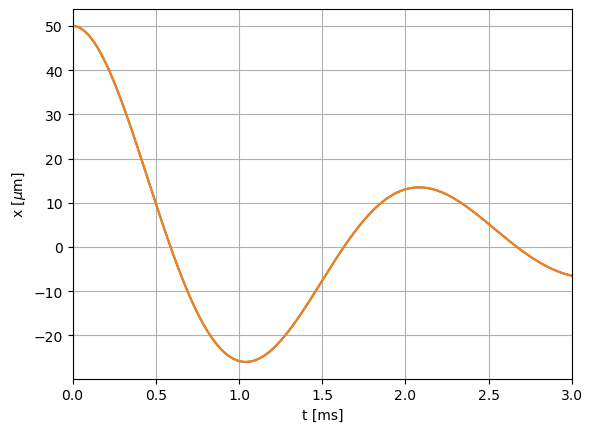

In [337]:
fitfunc = lambda t, *args: args[0]*np.exp(-args[1]*t/2)*np.cos(np.sqrt((args[2])**2 - (args[1])**2/4)*t + args[3]) + args[4]
fit, cov = curve_fit(fitfunc, sol.t*t_unit, sol.r[2]*cm_unit, p0=[0.05,3e3,3e3,0,0], maxfev=100000)
print(fit[1],"+-",np.sqrt(cov[1,1]))
print(fit[2],"+-",np.sqrt(cov[2,2]))
print((fit[2])**2/(fit[1]))
fig, ax = plt.subplots(1, 1)
ax.plot(sol.t*t_unit*1000,sol.r[2]*cm_unit*1e4)
ax.plot(sol.t*t_unit*1000,fitfunc(sol.t*t_unit,*fit)*1e4)
ax.set_xlabel('t [ms]')
ax.set_ylabel('x [$\\mu$m]')
fig.subplots_adjust(left=0.12,right=0.9)
ax.grid(True)
ax.set_xlim(0,3)

In [ ]:
fitfunc = lambda t, *args: args[0]*np.exp(-args[1]*t/2)*np.cos(np.sqrt((args[2])**2 - (args[1])**2/4)*t + args[3]) + args[4]
fit, cov = curve_fit(fitfunc, sol.t*t_unit, sol.r[2]*cm_unit, p0=[0.05,3e3,3e3,0,0], maxfev=100000)

In [331]:
print(fit[1],"+-",np.sqrt(cov[1,1]))
print(fit[2],"+-",np.sqrt(cov[2,2]))
print((fit[2])**2/(fit[1]))

1405.5923635834445 +- 1.5109385657361815e-05
3210.6300528056377 +- 9.259897104544578e-06
7333.666291199068


(0.0, 3.0)

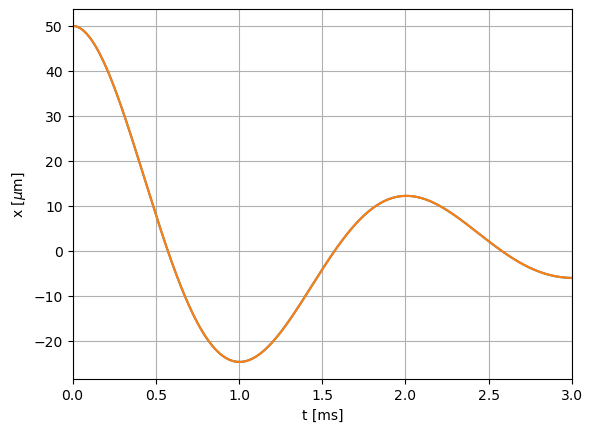

In [332]:
fig, ax = plt.subplots(1, 1)
ax.plot(sol.t*t_unit*1000,sol.r[2]*cm_unit*1e4)
ax.plot(sol.t*t_unit*1000,fitfunc(sol.t*t_unit,*fit)*1e4)
ax.set_xlabel('t [ms]')
ax.set_ylabel('x [$\\mu$m]')
fig.subplots_adjust(left=0.12,right=0.9)
ax.grid(True)
ax.set_xlim(0,3)

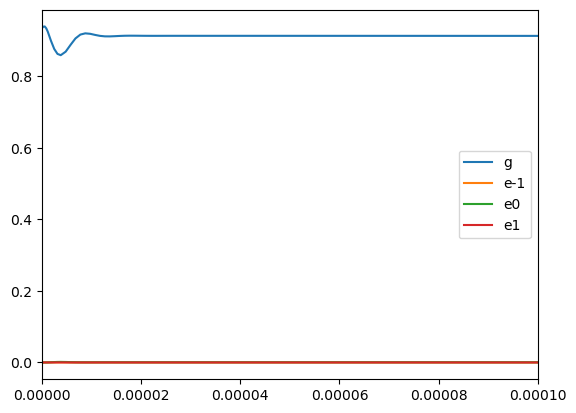

In [ ]:
[plt.plot(sol.t*t_unit*1000, np.abs(sol.rho[i,i])**2, label=["g","e-1","e0","e1"][i]) for i in range(4)]
plt.legend()
plt.xlim(0,0.0001)
plt.show()

In [ ]:
(0.2/(112/amu_unit))*accel_unit/30000

1.634776942250748

In [ ]:
rateeq.set_initial_position_and_velocity(np.array([-8/cm_unit, 0., 0.]),np.array([vel*np.cos(np.radians(angle))/velocity_unit, vel*np.sin(np.radians(angle))/velocity_unit, 0.]))
rateeq.set_initial_pop(np.array([1., 0., 0., 0.]))
rateeq.evolve_motion([0., 5e-2/t_unit], progress_bar=True, max_step = 1e-5/t_unit, rtol=1e-3, atol=[1,1,1,1,1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-3/cm_unit,1e-3/cm_unit,1e-3/cm_unit],method="Radau")
sol = rateeq.sol

Completed in 20.01 s.                                               


In [ ]:
10/velocity_unit

0.44

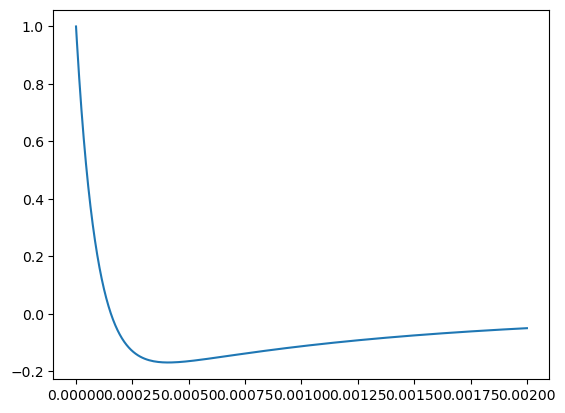

In [ ]:
plt.plot(sol.t*t_unit,sol.v[0]*velocity_unit)

In [ ]:
1e-2*0.15/0.05

0.03

In [ ]:
(sol.r[0][-1]*cm_unit - sol.r[0][0]*cm_unit)/(sol.t[-1]*t_unit - sol.t[0]*t_unit)

9999.999859855407

In [ ]:
velocity_unit

22.727272727272727